In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
import myfunc as mf

# Import the dataset
data = pd.read_csv('ESE4_CC.csv')

# Inspect the dataset
print(data.head())
print(data.info())

      life  copy  week
0  15.6135     1     1
1  10.8930     2     1
2  13.4460     3     1
3  22.7025     1     2
4   8.5710     2     2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   life    42 non-null     float64
 1   copy    42 non-null     int64  
 2   week    42 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 1.1 KB
None


In [2]:
life=data['life']

Number of points n = 42
Mean = 16.20


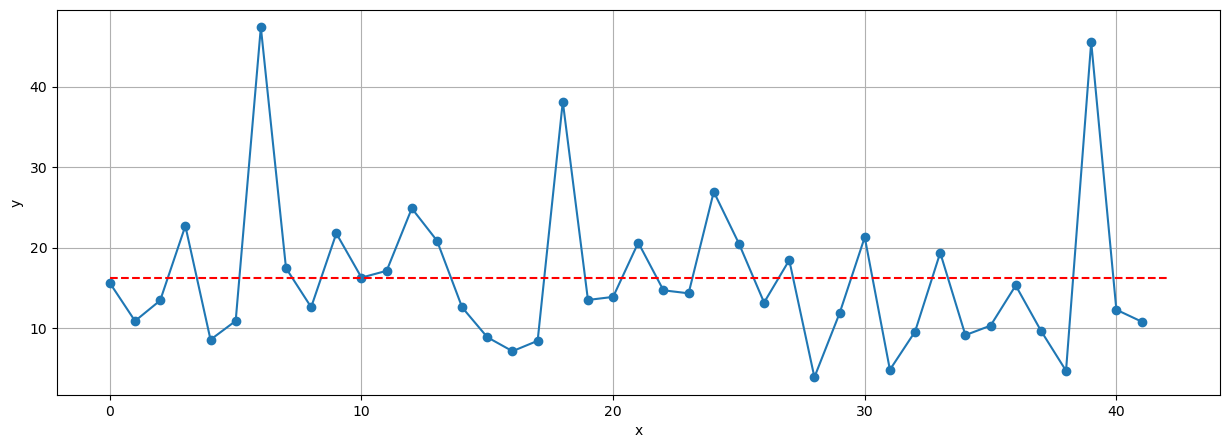

In [3]:
mf.single_ts_plot(life)
#sembra staz

p-value of the Shapiro-Wilk test: 0.000


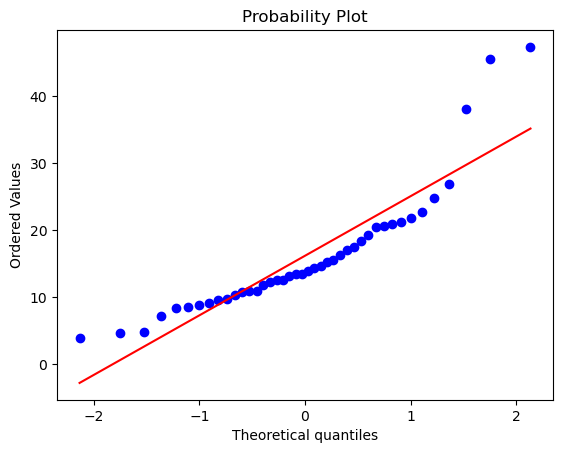

Reject H0: the data are not normal


In [4]:
mf.shapiroqq(life)

Runs test statistic = 0.063
Runs test p-value = 0.950
Accept H0: the data are random


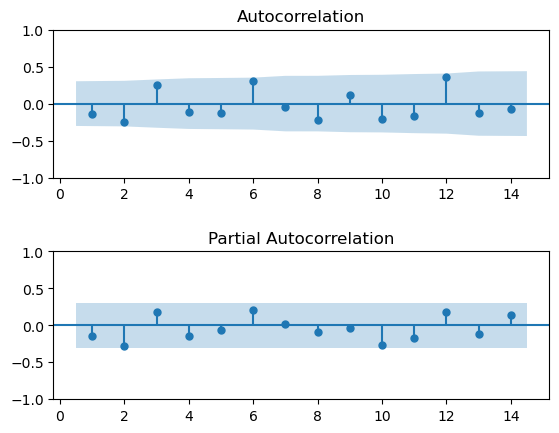

In [5]:
mf.runs(life)
mf.acfpacf(life)

In [6]:
mf.bartlett_test(life,3)

Test statistic rk = 0.244994
Rejection region at 0.302429, which is the value of z_alpha2/np.sqrt(n)
The null hypothesis is accepted


il Lambda migliore è= 0.012
ma il lambda usato è 0
p-value of the Shapiro-Wilk test: 0.554
box cox succeeded :)


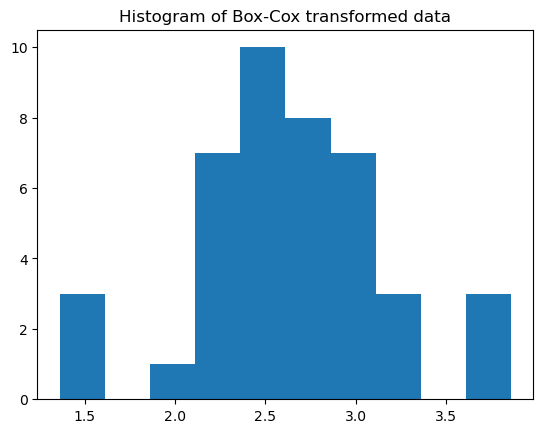

In [7]:
[data['life_norm'],lmbda]=mf.boxcox(data,'life')

In [8]:
life_norm=data['life_norm']

Number of points n = 42
Mean = 2.64


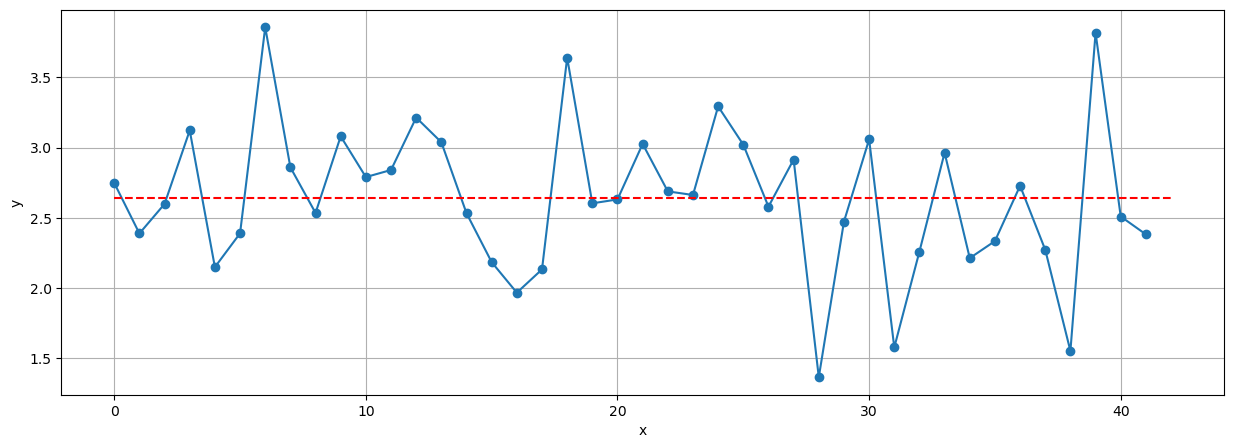

Runs test statistic = 0.015
Runs test p-value = 0.988
Accept H0: the data are random


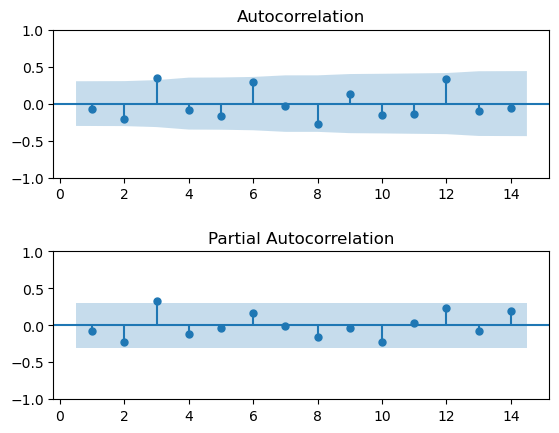

Test statistic rk = 0.350641
Rejection region at 0.302429, which is the value of z_alpha2/np.sqrt(n)
The null hypothesis is rejected


In [9]:
mf.single_ts_plot(life_norm)
mf.runs(life_norm)
mf.acfpacf(life_norm)
mf.bartlett_test(life_norm,3)

in sostanza ora che ho normalizzato i dati la correlazione al lag3 si fa sentire!
sembra esserci un chiaro batch effect!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


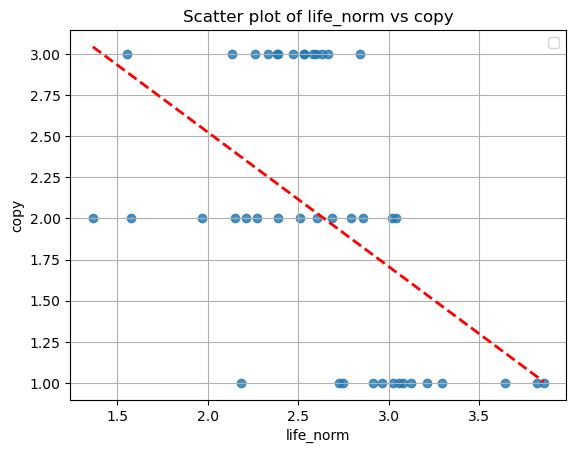

In [10]:
mf.scatter_plot_nice_h(data,'life_norm','copy')
#soprattutto la prima copy sembra essere diversa ma si potrebbero comunque fare 3 dummies
#prendiamo la strada di fare la dummy solo per la copy1

In [11]:
data['copy1']=np.zeros(len(data))
for i in range (len(data)):
    if data['copy'].iloc[i]==1:
        data['copy1'].iloc[i]=1

c:\Users\alyuk\anaconda3\envs\qda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
import statsmodels.api as sm
import qda
x = data['copy1'] #se solo un regressore togli le doppie quadre e metti singole
x = sm.add_constant(x) 
y = data['life_norm']
model = sm.OLS(y, x).fit()
qda.summary(model)


REGRESSION EQUATION
-------------------
life_norm =  + 2.405 const + 0.713 copy1

COEFFICIENTS
------------
 Term   Coef  SE Coef  T-Value    P-Value
const 2.4048   0.0801  30.0193 4.7328e-29
copy1 0.7133   0.1388   5.1405 7.5588e-06

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.4239 0.3978     0.3828

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS  F-Value    P-Value
Regression  1.0   4.7482   4.7482  26.4248 7.5588e-06
     const  1.0 161.9253 161.9253 901.1581 4.7328e-29
     copy1  1.0   4.7482   4.7482  26.4248 7.5588e-06
     Error 40.0   7.1874   0.1797      NaN        NaN
     Total 41.0  11.9356      NaN      NaN        NaN


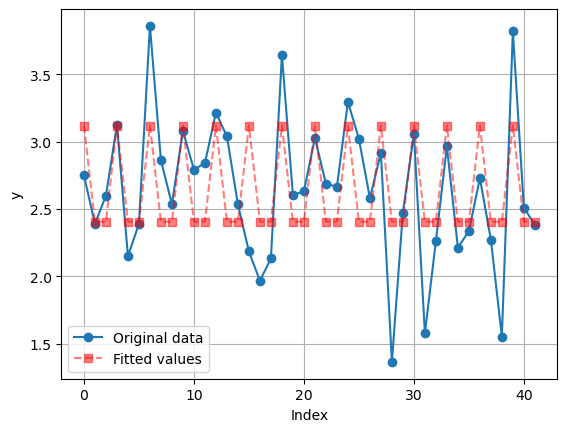

Shapiro-Wilk test p-value on the residuals = 0.101


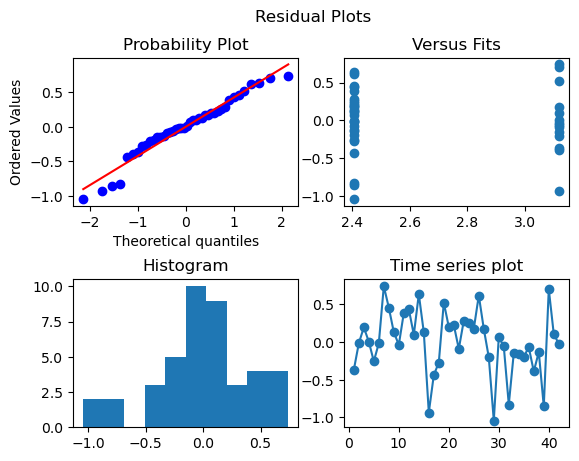

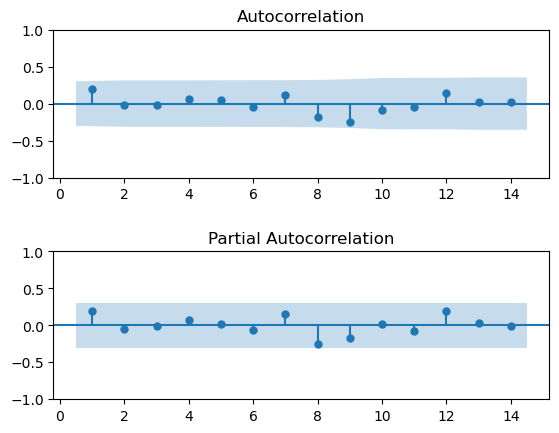

Runs test statistic = -2.187
Runs test p-value = 0.029
Reject H0: the data are not random


In [13]:
mf.plotyvsfits(y,model)
mf.shapirplusresplots(model)
mf.acfpacf(model.resid)
mf.runs(model.resid)

i residui non sono giudicati come random dal runstest ma l'acfpacf non concorda diciamo

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox
L=3
alpha=0.05
critical_value=stats.chi2.ppf(1-alpha,L)
lbq_test = acorr_ljungbox(model.resid, lags=[L], return_df=True)
print('LBQ test statistic at lag %d = %f' % (L, lbq_test.loc[L,'lb_stat']))
print('LBQ critical value at lag %d = %f' % (L, critical_value))
print('LBQ test p-value at lag %d = %f' % (L, lbq_test.loc[L,'lb_pvalue']))

#stando ad LBQ accetteremmo randomness, proviamo anche bartlett fino a L=3


LBQ test statistic at lag 3 = 1.804432
LBQ critical value at lag 3 = 7.814728
LBQ test p-value at lag 3 = 0.613971


In [15]:
mf.bartlett_test(model.resid,1,alpha/3)
mf.bartlett_test(model.resid,2,alpha/3)
mf.bartlett_test(model.resid,3,alpha/3)

#anche qui, con la correzione di bonferroni la randomness è accettata
#per majority voting deciderei che il modello è adeguato

Test statistic rk = 0.198769
Rejection region at 0.369399, which is the value of z_alpha2/np.sqrt(n)
The null hypothesis is accepted
Test statistic rk = -0.013629
Rejection region at 0.369399, which is the value of z_alpha2/np.sqrt(n)
The null hypothesis is accepted
Test statistic rk = -0.017823
Rejection region at 0.369399, which is the value of z_alpha2/np.sqrt(n)
The null hypothesis is accepted


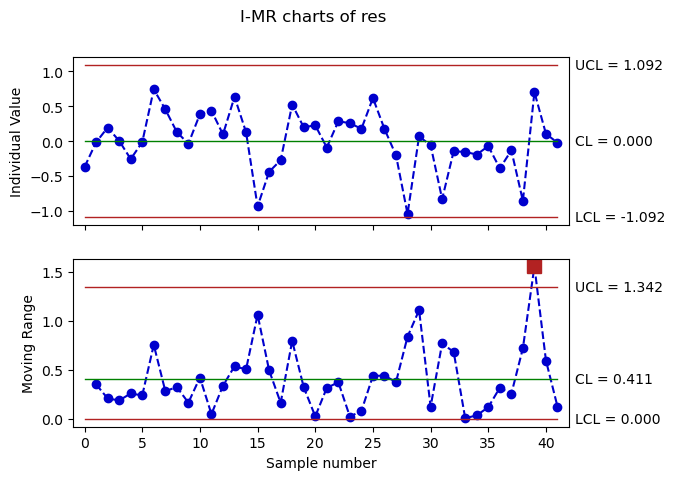

In [16]:
df_SCC = pd.DataFrame({'res': model.resid}) #lo chiamo direttamente df_SCC
df_SCC = qda.ControlCharts.IMR(df_SCC, 'res',K=3)


c'è un OOC sull'MR chart dei residui, come sempre per essere sicuri che non sia un finto allarme dovuto alla non normalità dell'MR possiamo trasformarlo!

Lambda = 0.377
p-value of the Shapiro-Wilk test: 0.957
box cox succeeded :)


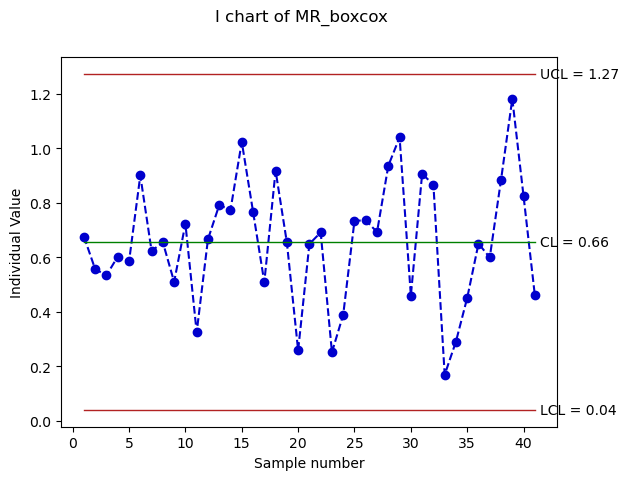

In [21]:
df_MR_boxcox=mf.IonMRresBoxCox(df_SCC,'no')

Now no out-of-control is signaled. However, there seems to be a funnel effect in the MR time series. 
Attention should be paid to this pattern. 